In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox ,probplot
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_auc_score, roc_curve, auc

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [248]:
# df = pd.read_csv('C:/Users/danie/Desktop/Bootcamp_Data/modulo_3/06-Proyecto_final/data/transactions_processed.csv')
df = pd.read_csv('C:/Users/danie/Desktop/Bootcamp_Data/modulo_3/06-Proyecto_final/data/transactions_processed2.csv')

In [249]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour', 'Shipping Billing Same'],
      dtype='object')

Data Transformation:

As we can see on the EDA notebook, we have some columns that are not useful for the model, so we need to remove them.

In [250]:
df.drop(columns=['Transaction ID', 'Customer ID', 'Transaction Date' , 'Customer Location','IP Address','Shipping Address', 'Billing Address'], axis=1, inplace=True)
# columnas extras que se eliminan de este dataset para prueba de modelo
# df.drop(columns = ['Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Device Used', 'Shipping Billing Same'] , axis=1, inplace=True)

In [251]:
#create a new column 'Transaction Hour Range' with the following bins, for use to best performance in the model
bins = [0, 6 , 12, 18, 24]
labels = [f"{i}-{j} hours" for i, j in zip(bins[:-1], bins[1:])]
df['Transaction Hour Range'] = pd.cut(df['Transaction Hour'], bins=bins, labels=labels, right=False)

#Create a new column 'Account Age Range' with the following bins, for use to best performance in the model

bins = [0, 60, 120, 180, 240, 300, 365]
labels = [f"{i}-{j}" for i, j in zip(bins[:-1], bins[1:])]

df['Account Age Range'] = pd.cut(df['Account Age Days'], bins=bins, labels=labels, right=False)

df.drop(columns=['Account Age Days','Transaction Hour'], axis=1, inplace=True)

Another thing that we need is a transformation of the column 'Transaction Amount', because this distribution is right-skewed. we will apply a box-cox transformation to make it more normal. and do a test to check if the transformation was successful.

Lambda used for Box-Cox transformation: 0.09284324748066126


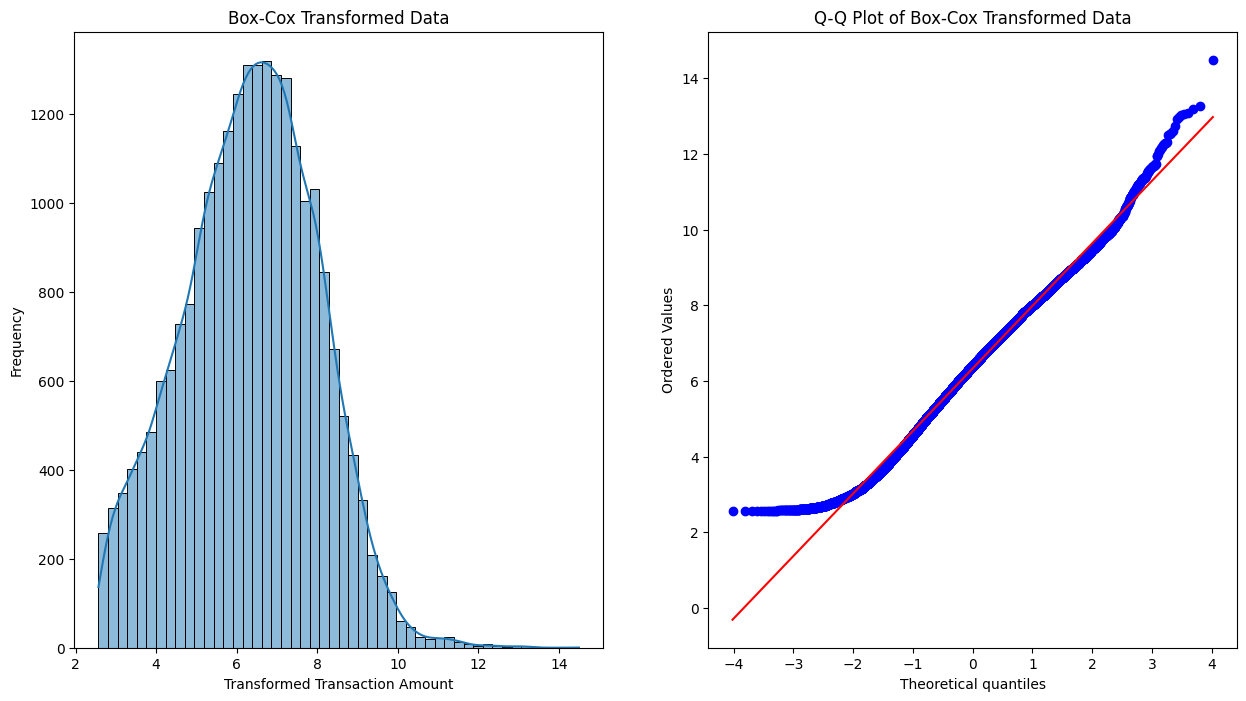

In [252]:
# Apply the Box-Cox transformation to the 'Transaction Amount' feature
df['Transaction Amount Transformed'], lam = boxcox(df['Transaction Amount'])
print(f"Lambda used for Box-Cox transformation: {lam}")
df.drop(columns=['Transaction Amount'], axis=1, inplace=True)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount Transformed'], bins=50, kde=True)
plt.title('Box-Cox Transformed Data')
plt.xlabel('Transformed Transaction Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
probplot(df['Transaction Amount Transformed'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Data')

plt.show()

The next step is split the data into train and test, define the target variables and the features.

In [253]:
# Define the categorical and numeric features
cate_features = ['Transaction Hour Range', 'Account Age Range','Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Device Used', 'Shipping Billing Same']
# cate_features = ['Transaction Hour Range', 'Account Age Range'] # da  valores muy bajos en el modelo 0.70 en roc_auc
num_features = ['Transaction Amount Transformed']

# split the data into X and y
X = df[cate_features + num_features]
y = df['Is Fraudulent']

# Split the data into training and testing sets , aplying stratify to balance the classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



First start with the data transformation.
 - for the categorical columns, we will use the OneHotEncoder, to transform the categorical columns into numerical columns.
 - for the numerical columns, because the box-cox transformation do the normalization, we will use the MinMaxScaler to scale the data in the range [0,1]

In [218]:
# data transformation
column_transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cate_features)
    ])
# X= column_transformer.fit_transform(X)
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

Now we do a series of steps to prepare the train data for the model:
- Because we have a problem with the class imbalance, we will use a Sampling technique to balance the classes, let's see which one is the best sampling technique.

In [255]:
# #### test de un proyecto de kaggel
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE

# # Define the categorical and numeric features
# cate_features = ['Transaction Hour Range', 'Account Age Range','Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Device Used', 'Shipping Billing Same']
# # cate_features = ['Transaction Hour Range', 'Account Age Range'] # da  valores muy bajos en el modelo 0.72 en roc_auc
# num_features = ['Transaction Amount Transformed']

# # split the data into X and y
# X = df[cate_features + num_features]
# y = df['Is Fraudulent']

# # data transformation
# column_transformer = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), num_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cate_features)
#     ])
# X= column_transformer.fit_transform(X)

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X ,y)
# print(X_resampled.shape,y_resampled.shape)

# # SMOTE
# X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)
# print(classification_report(y_test,y_pred))

(44824, 105) (44824,)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4555
           1       0.99      0.97      0.98      4410

    accuracy                           0.98      8965
   macro avg       0.98      0.98      0.98      8965
weighted avg       0.98      0.98      0.98      8965



In [212]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

'''
Function that evaluates different sampling techniques for a binary classification model using logistic regression,
and returns a DataFrame with the obtained results. It includes oversampling, undersampling, and their combinations,
and identifies the best result based on the F1 score.

Parameters:
- X (pd.DataFrame): Features of the dataset.
- y (pd.Series): Target variable of the dataset.

Steps:
1. Define the logistic regression model.
2. Define oversampling and undersampling techniques.
3. Evaluate each oversampling technique individually.
4. Evaluate each undersampling technique individually.
5. Evaluate combinations of oversampling and undersampling techniques.
6. Collect metrics (ROC AUC, accuracy, F1 score) for each method.
7. Identify and print the best result based on the F1 score.

Returns:
- pd.DataFrame: DataFrame with the results of all sampling techniques evaluated.
'''

def evaluate_sampling_techniques(X, y):
    # Define the model
    model = LogisticRegression(solver='liblinear')

    # Define oversampling and undersampling techniques
    over_sampling_methods = {
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42)
    }

    under_sampling_methods = {
        'TomekLinks': TomekLinks(),
        'NearMiss': NearMiss(),
        'RandomUnderSampler': RandomUnderSampler(random_state=42)
    }

    results = []

    # Evaluate oversampling
    for method_name, sampler in over_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Oversampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1})
    
    # Evaluate undersampling
    for method_name, sampler in under_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1})

    # Evaluate combinations of over and under sampling
    for over_name, over_sampler in over_sampling_methods.items():
        for under_name, under_sampler in under_sampling_methods.items():
            pipeline = Pipeline([('over', over_sampler), ('under', under_sampler)])
            X_resampled, y_resampled = pipeline.fit_resample(X, y)
            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            roc_auc = roc_auc_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            results.append({
                'Method': f'{over_name} + {under_name}',
                'Type': 'Both',
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'F1': f1,
                'Recall': recall
            })

    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['F1'].idxmax()]
    print("Best result based on F1 score:")
    print(best_result)
    return results_df

# Assuming 'X' and 'y' are already defined.
results = evaluate_sampling_techniques(X, y)
results

Best result based on F1 score:
Method      SMOTE + RandomUnderSampler
Type                              Both
ROC AUC                         0.7616
Accuracy                        0.7616
F1                            0.762624
Name: 8, dtype: object


,Method,Type,ROC AUC,Accuracy,F1
0,SMOTE,Oversampling,0.759816,0.759816,0.760315
1,ADASYN,Oversampling,0.756078,0.756063,0.756426
2,RandomOverSampler,Oversampling,0.731930,0.731930,0.731111
3,TomekLinks,Undersampling,0.533221,0.949018,0.124069
4,NearMiss,Undersampling,0.622616,0.622616,0.604850
5,RandomUnderSampler,Undersampling,0.704360,0.704360,0.709505
6,SMOTE + TomekLinks,Both,0.760191,0.760190,0.760795
7,SMOTE + NearMiss,Both,0.757585,0.757585,0.757260
8,SMOTE + RandomUnderSampler,Both,0.761600,0.761600,0.762624
9,ADASYN + TomekLinks,Both,0.757184,0.757184,0.756567


In [184]:
# funcion haciendo el split despues del sampling 
## con errores de tamaño de datos
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline

'''
Function that evaluates different sampling techniques for a binary classification model using logistic regression, 
and returns a DataFrame with the obtained results. It includes oversampling, undersampling, and their combinations, 
and identifies the best result based on the F1 score.

Parameters:
- X_test (pd.DataFrame): Features of the testing set.
- y_test (pd.Series): Target variable of the testing set.
- X_train (pd.DataFrame): Features of the training set.
- y_train (pd.Series): Target variable of the training set.

Samplings Techniques:
- Oversampling: SMOTE, ADASYN, RandomOverSampler.
- Undersampling: TomekLinks, NearMiss, RandomUnderSampler.

Steps:
1. Define the logistic regression model.
2. Define oversampling and undersampling techniques.
3. Evaluate each oversampling technique individually.
4. Evaluate each undersampling technique individually.
5. Evaluate combinations of oversampling and undersampling techniques.
6. Collect metrics (ROC AUC, accuracy, F1 score) for each method.
7. Identify and print the best result based on the F1 score.

Returns:
- pd.DataFrame: DataFrame with the results of all sampling techniques evaluated.
'''

def evaluate_sampling_techniques(X, y):
    # Define the model
    model = LogisticRegression(solver='liblinear')

    # Define oversampling and undersampling techniques
    over_sampling_methods = {
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42)
    }

    under_sampling_methods = {
        'TomekLinks': TomekLinks(),
        'NearMiss': NearMiss(),
        'RandomUnderSampler': RandomUnderSampler(random_state=42)
    }

    results = []

    # Evaluate oversampling
    for method_name, sampler in over_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Oversampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1})
    
    # Evaluate undersampling
    for method_name, sampler in under_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1})

    # Evaluate combinations of over and under sampling
    for over_name, over_sampler in over_sampling_methods.items():
        for under_name, under_sampler in under_sampling_methods.items():
            pipeline = Pipeline([('over', over_sampler), ('under', under_sampler)])
            X_resampled, y_resampled = pipeline.fit_resample(X, y)
            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            roc_auc = roc_auc_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            results.append({
                'Method': f'{over_name} + {under_name}',
                'Type': 'Both',
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'F1': f1
            })

    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['F1'].idxmax()]
    print("Best result based on F1 score:")
    print(best_result)
    return results_df


In [244]:
## funcion que evalue el mejor sampling para el modelo, con el split antes de aplicar el sampling
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score , recall_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline

'''
Function that evaluates different sampling techniques for a binary classification model using logistic regression, 
and returns a DataFrame with the obtained results. It includes oversampling, undersampling, and their combinations, 
and identifies the best result based on the F1 score.

Parameters:
- X_test (pd.DataFrame): Features of the testing set.
- y_test (pd.Series): Target variable of the testing set.
- X_train (pd.DataFrame): Features of the training set.
- y_train (pd.Series): Target variable of the training set.

Samplings Techniques:
- Oversampling: SMOTE, ADASYN, RandomOverSampler.
- Undersampling: TomekLinks, NearMiss, RandomUnderSampler.

Steps:
1. Define the logistic regression model.
2. Define oversampling and undersampling techniques.
3. Evaluate each oversampling technique individually.
4. Evaluate each undersampling technique individually.
5. Evaluate combinations of oversampling and undersampling techniques.
6. Collect metrics (ROC AUC, accuracy, F1 score) for each method.
7. Identify and print the best result based on the F1 score.

Returns:
- pd.DataFrame: DataFrame with the results of all sampling techniques evaluated.
'''

def evaluate_sampling_techniques(X_test, y_test, X_train, y_train):
    # Define the model
    model = LogisticRegression(solver='liblinear')

    # Define oversampling and undersampling techniques
    over_sampling_methods = {
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42)
    }

    under_sampling_methods = {
        'TomekLinks': TomekLinks(),
        'NearMiss': NearMiss(),
        'RandomUnderSampler': RandomUnderSampler(random_state=42)
    }

    results = []

    # Evaluate oversampling
    for method_name, sampler in over_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
    
    # Evaluate undersampling
    for method_name, sampler in under_sampling_methods.items():
        pipeline = Pipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})

    # Evaluate combinations of over and under sampling
    for over_name, over_sampler in over_sampling_methods.items():
        for under_name, under_sampler in under_sampling_methods.items():
            pipeline = Pipeline([
                ('over', over_sampler),
                ('under', under_sampler),
                ('model', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            roc_auc = roc_auc_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            results.append({
                'Method': f'{over_name} + {under_name}',
                'Type': 'Both',
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'F1': f1,
                'Recall': recall
            })

    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['F1'].idxmax()]
    print("Best result based on Accuracy score:")
    print(best_result)
    return results_df

In [245]:
results = evaluate_sampling_techniques(X_train , y_train, X_test, y_test)

Best result based on Accuracy score:
Method              SMOTE
Type        Undersampling
ROC AUC          0.707496
Accuracy         0.783519
F1               0.229335
Recall           0.622699
Name: 0, dtype: object


In [246]:
results

,Method,Type,ROC AUC,Accuracy,F1,Recall
0,SMOTE,Undersampling,0.707496,0.783519,0.229335,0.622699
1,ADASYN,Undersampling,0.707802,0.781351,0.228443,0.625767
2,RandomOverSampler,Undersampling,0.710897,0.765219,0.222728,0.650307
3,TomekLinks,Undersampling,0.523573,0.948062,0.090741,0.050102
4,NearMiss,Undersampling,0.481529,0.326546,0.091344,0.654397
5,RandomUnderSampler,Undersampling,0.702595,0.723806,0.202748,0.678937
6,SMOTE + TomekLinks,Both,0.707496,0.783519,0.229335,0.622699
7,SMOTE + NearMiss,Both,0.707468,0.783466,0.229292,0.622699
8,SMOTE + RandomUnderSampler,Both,0.707468,0.783466,0.229292,0.622699
9,ADASYN + TomekLinks,Both,0.707802,0.781351,0.228443,0.625767


In [ ]:
# results = evaluate_sampling_techniques(X_test, y_test, X_train, y_train)

As we can see the best sampling technique is the SMOTETomek, so we will use this technique to balance the classes.

In [189]:
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

def evaluate_models(X_train, y_train, X_test, y_test):
    # Define the models to evaluate
    models = {
        'Logistic Regression': (LogisticRegression(class_weight='balanced', random_state=42), {
            'max_iter': [1000, 2000, 3000],
            'C': [0.01, 0.1, 1, 10, 100]
        }),
        'Random Forest': (RandomForestClassifier(class_weight='balanced', random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None]
        }),
        'Balanced Random Forest': (BalancedRandomForestClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None]
        }),
        'Easy Ensemble Classifier': (EasyEnsembleClassifier(random_state=42), {
            'n_estimators': [10, 50, 100, 300]
        }),
        'LGBMClassifier': (LGBMClassifier(random_state=42), {
            'n_estimators': [100, 200],
            'num_leaves': [31, 64],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        'XGBClassifier': (XGBClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        'AdaBoost': (AdaBoostClassifier(random_state=42), {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.1, 1]
        }),
        'K-Nearest Neighbors': (KNeighborsClassifier(), {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }),
    }

    # Function to evaluate the models with GridSearchCV
    best_model = None
    best_score = 0
    for name, (model, params) in models.items():
        grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        y_pred = best_estimator.predict(X_test)
        roc_auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1] if hasattr(best_estimator, 'predict_proba') else best_estimator.decision_function(X_test))
        print(f"{name} - ROC-AUC: {roc_auc}")
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = best_estimator
    return best_model, best_score

In [195]:
# Evaluate the models
best_model, best_score = evaluate_models(X_train_res, y_train_res, X_test, y_test)
print(f"Mejor modelo: {best_model} con ROC-AUC: {best_score}")

# print the classification report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test))}')

Logistic Regression - ROC-AUC: 0.7938249415825905
Random Forest - ROC-AUC: 0.7764921579884665


c:\Users\danie\Desktop\Bootcamp_Data\boot_data\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\danie\Desktop\Bootcamp_Data\boot_data\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\danie\Desktop\Bootcamp_Data\boot_data\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence t

Balanced Random Forest - ROC-AUC: 0.7669405915974008
Easy Ensemble Classifier - ROC-AUC: 0.8182839177512131
[LightGBM] [Info] Number of positive: 17921, number of negative: 17921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16788
[LightGBM] [Info] Number of data points in the train set: 35842, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier - ROC-AUC: 0.7788649652786666
XGBClassifier - ROC-AUC: 0.7498098463046189
Gradient Boosting - ROC-AUC: 0.8125367965684572


c:\Users\danie\Desktop\Bootcamp_Data\boot_data\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - ROC-AUC: 0.8093882901891664
K-Nearest Neighbors - ROC-AUC: 0.6486576794666921
Mejor modelo: EasyEnsembleClassifier(random_state=42) con ROC-AUC: 0.8182839177512131
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4483
           1       0.15      0.71      0.25       244

    accuracy                           0.78      4727
   macro avg       0.57      0.75      0.56      4727
weighted avg       0.94      0.78      0.84      4727

ROC-AUC: 0.8182839177512131


### metodo de kaggle

In [19]:
X = df.drop('Is Fraudulent', axis=1)
y = df['Is Fraudulent']
X.shape, y.shape

((23634, 9), (23634,))

In [18]:
df['Payment Method'] = df['Payment Method'].map({"debit card":0,"credit card":1,"PayPal":2,"bank transfer":3})
df['Product Category'] = df['Product Category'].map({"home & garden":0,"electronics":1,"toys & games":2,"clothing":3,"health & beauty":4})
df['Device Used'] = df['Device Used'].map({"desktop":0,"mobile":1,"tablet":2,})
numeric_features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Shipping Billing Same
0,-0.663192,2,1,-1.409202,0.543476,0,0,0.962314,1.680964,1
1,0.255186,1,1,-0.000387,0.043938,2,0,0.412896,-1.613924,1
2,0.393393,0,2,1.408427,-0.555507,0,0,1.688663,-0.467876,0
3,-0.473680,1,1,1.408427,1.043013,1,0,1.362737,1.251196,1
4,-0.538635,1,3,1.408427,0.743291,0,0,-0.583505,0.534916,1


In [43]:
rus = RandomUnderSampler(sampling_strategy='majority' , random_state=42)
X_under_resampled, y_under_resampled = rus.fit_resample(X_train, y_train)
print(X_under_resampled.shape,y_under_resampled.shape)

(35714, 12) (35714,)


In [ ]:
# Random Under Sampler
X_train,X_test,y_train,y_test = train_test_split(X_under_resampled,y_under_resampled,test_size=0.2,random_state=42)
model = RandomForestClassifier(random_state=1234)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

In [86]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape,y_resampled.shape)

# SMOTE
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

(44824, 12) (44824,)
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      4555
           1       0.71      0.72      0.72      4410

    accuracy                           0.72      8965
   macro avg       0.72      0.72      0.72      8965
weighted avg       0.72      0.72      0.72      8965



In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy.stats import boxcox